In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "monospace"
import pandas as pd 
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.lines import Line2D
import plotting_utils

plt.rcParams.update({
    "figure.facecolor":  (1,  1, 1, 1), 
    "axes.facecolor":    (1, 1, 1, 1), 
    "savefig.facecolor": (1, 1, 1, 1), 
})

# Get Thresholds for PSNR, NMSE

__Performance metrics:__
- PSNR: Peak signal-to-noise ratio (expressed in devibles - noise: error introduced by compression) --> approximation to human perception of reconstruction quality --> log to MSE
- NMSE: Normalized mean-square error (normalized mean squared difference between estimated and actual values)
- SSIM: Structural similarity (between two images)

In [8]:
# some helper functions
def get_xlim(eval_metric, series):
    if eval_metric == 'SSIM':
        down_lam = 0.01
        up_lam = min([0.025, 1-max(series)])
    elif eval_metric == 'NMSE':
        down_lam = 0.0025
        up_lam = 0.0025
    elif eval_metric == 'PSNR':
        down_lam = 2
        up_lam = 2
    else:
        lam = 0
    
    lower = min(series) - down_lam
    upper = max(series) + up_lam

    return (lower, upper)


def get_ticks(eval_metric, xlim):
    if eval_metric == 'SSIM':
        major_tick = 0.01
        minor_tick = 0.005
    elif eval_metric == 'NMSE':
        major_tick = round((xlim[1] - xlim[0])/10, ndigits=3)
        minor_tick = major_tick/2
    elif eval_metric == 'PSNR':
        major_tick = 1
        minor_tick = 0.5 
    else:
        major_tick = 0
        minor_tick = 0  
        
    return major_tick, minor_tick

# Modified version 
def get_plotting_data(df, network_keys, anatomy_keys, eval_metric, network_column):
    df_final = None
    cols = [network_column, 'dset', eval_metric, eval_metric+'_std']
    for nkey in network_keys:
        for ecol in anatomy_keys:
            df_eval = df[df[network_column]==nkey]
            row = [f'{nkey.ljust(10)}', f'{ecol.ljust(14)}']
            count = df_eval[df_eval['anatomy']==ecol].count()[eval_metric]
            metric_mean = df_eval[df_eval['anatomy']==ecol].mean()[eval_metric]
            metric_std = df_eval[df_eval['anatomy']==ecol].std()[eval_metric]
            row.append(metric_mean)
            row.append(metric_std)

            df_eval = pd.DataFrame([row], columns=cols)
            df_final = pd.concat([df_final, df_eval], ignore_index=True)
            x = df_final.set_index(network_column)[eval_metric].sort_values(ascending=True)
            y = df_final.set_index('dset')[eval_metric].sort_values(ascending=True)

    x.index = x.index.str.strip()
    y.index = y.index.str.strip()

    return x, y

# Ranked List for Scanner Models per Network

(0.9410971849856079, 0.999337267376624)


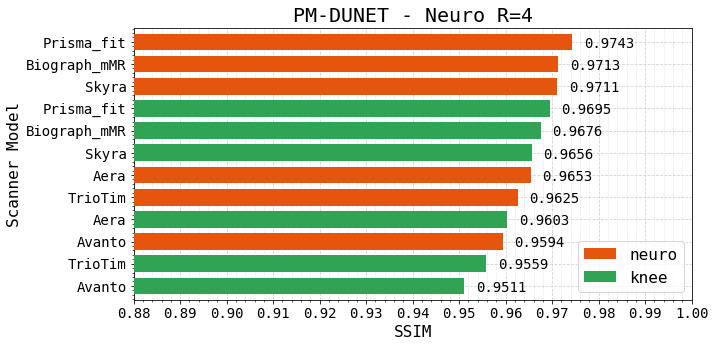

In [51]:
anatomy = 'brain'
Reval = 4
dataset = 'multicoil_train'

eval_metric = 'SSIM'
eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_train = pd.read_csv(f'./resources/{anatomy}/{dataset}.csv')

networks = df_raw.network.unique()
network_type = 'PM-DUNET'

figid, title, xlim = plotting_utils.get_plotting_info(anatomy, Reval)
legend = plotting_utils.get_legend(eval_dset, disp_dset)

df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R{Reval}.csv')
acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

df = df_raw
# evaluate wrt. SSIM and drop other measures
drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
df.drop(columns=drop_metric, inplace=True)

# drop rows that are not of the acquisition type
df = df[df.network == network_type]

model_keys = df['systemModel'].unique()
anatomy_keys = df['anatomy'].unique()

# only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

x, y = get_plotting_data(df, model_keys, anatomy_keys, eval_metric, network_column='systemModel')
xlim = get_xlim(eval_metric, x)
print(xlim)
xlim = (0.88, 1.0)

# setup figure
ax = x.plot(kind='barh',
            xlim=xlim,
            figsize=(10,5),
            width=0.75,
            color=plotting_utils.get_color(y.index), 
            zorder=3,  
            fontsize=14)

ax.set_title(network_type + ' - ' + title , fontsize=20)
ax.set_ylabel('Scanner Model', fontsize=16)
ax.set_xlabel(eval_metric, fontsize=16)
ax.legend(handles=legend, loc='lower right', fontsize=16)

# display metric
for i, v in enumerate(y):
    # get number of samples used for training from training dataframe
    num_samples = len(df_train[df_train.systemModel == x.index[i]])
    #ax.text(v + 0.0025, i - 0.25, f'{v:0.4f} - {num_samples}', color='black', fontsize=14, zorder=2)
    ax.text(v + 0.0025, i - 0.25, f'{v:0.4f}', color='black', fontsize=14, zorder=2)

# add grid
ax.grid(zorder=0, color='lightgray', linestyle='dotted',which='minor',axis='x', alpha=0.8)
ax.grid(zorder=0, color='lightgray', linestyle='dashed',which='major')

ticks = get_ticks(eval_metric, xlim)
ax.xaxis.set_major_locator(MultipleLocator(ticks[0])) # change ticks
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.minorticks_on()

# Ranked List for Scanner Models per Network - automated

In [ ]:
anatomy = 'brain'
Reval = 4
dataset = 'multicoil_train'

eval_metric = 'SSIM'
eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_train = pd.read_csv(f'./resources/{anatomy}/{dataset}.csv')
df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R{Reval}.csv')

networks = df_raw.network.unique()
figid, title, _ = plotting_utils.get_plotting_info(anatomy, Reval)
legend = plotting_utils.get_legend(eval_dset, disp_dset)

print(networks)

acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

for network_type in networks:
    df = df_raw
    # evaluate wrt. SSIM and drop other measures
    drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
    df = df.drop(columns=drop_metric, inplace=False)

    # drop rows that are not of the acquisition type
    df = df[df.network == network_type]

    model_keys = df['systemModel'].unique()
    anatomy_keys = df['anatomy'].unique()

    # only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
    anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

    x, y = get_plotting_data(df, model_keys, anatomy_keys, eval_metric, network_column='systemModel')
    xlim = get_xlim(eval_metric, x)

    # setup figure
    ax = x.plot(kind='barh',
                xlim=xlim,
                figsize=(10,5),
                width=0.75,
                color=plotting_utils.get_color(y.index), 
                zorder=3,  
                fontsize=14)

    ax.set_title(network_type + ' - ' + title , fontsize=20)
    ax.set_ylabel('Scanner Model', fontsize=16)
    ax.set_xlabel(eval_metric, fontsize=16)
    ax.legend(handles=legend, loc='lower right', fontsize=16)

    # display metric
    for i, v in enumerate(y):
        # get number of samples used for training from training dataframe
        num_samples = len(df_train[df_train.systemModel == x.index[i]])
        ax.text(v + 0.0025, i - 0.25, f'{v:0.4f} - {num_samples}', color='black', fontsize=14, zorder=2)

    # add grid
    ax.grid(zorder=0, color='lightgray', linestyle='dotted',which='minor',axis='x', alpha=0.8)
    ax.grid(zorder=0, color='lightgray', linestyle='dashed',which='major')

    ticks = get_ticks(eval_metric, xlim)
    ax.xaxis.set_major_locator(MultipleLocator(ticks[0])) # change ticks
    ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
    ax.minorticks_on()

    fig = ax.get_figure()
    #fig.savefig(f'./figures/figures_networks/test.png', bbox_inches='tight', dpi=300)
    fig.savefig(f'./figures/figures_networks/{network_type}/{figid}_ranked_{anatomy}_R{Reval}.png', bbox_inches='tight', dpi=300)
    print(f'./figures/figures_networks/{network_type}/{figid}_ranked_{anatomy}_R{Reval}.png')
    # clear figure for next network
    fig.clf()

# Ranked List for Networks - Acqusition Type

['GD-DUNET' 'PM-DUNET' 'VS-DUNET' 'UNET' 'VN' 'MoDL']


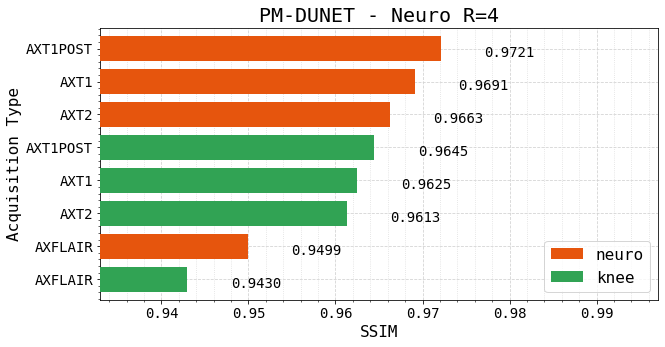

In [15]:
anatomy ='brain'
Reval = 4

acq_type = 'MoDL'
scanner_model = 'Skyra'

eval_metric = 'SSIM'
eval_dset = ['neuro','knee 100'] # name of dataset in csv
disp_dset = ['neuro','knee'] # display name of dataset

df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R{Reval}.csv')

networks = df_raw.network.unique()
network_type = 'PM-DUNET'
print(networks)

acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

figid, title, _ = plotting_utils.get_plotting_info(anatomy, Reval)
legend = plotting_utils.get_legend(eval_dset, disp_dset)

# drop columns we are currently not interested in evaluation
#df = df_raw.drop(columns=['receiverChannels', 'systemVendor', 'systemFieldStrength_T', 'filename', 'path', 'receiverChannels', 'TR', 'TE', 'TI', 'flipAngle_deg', 'sequence_type', 'echo_spacing'], inplace=False)

df = df_raw
# evaluate wrt. SSIM and drop other measures
drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
df.drop(columns=drop_metric, inplace=True)

# drop rows that are not of the acquisition type
df = df[df.network == network_type]

model_keys = df['acquisition'].unique()
anatomy_keys = df['anatomy'].unique()

# only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

x, y = get_plotting_data(df, model_keys, anatomy_keys, eval_metric, network_column='acquisition')
xlim = get_xlim(eval_metric='SSIM', series=x)
ticks = get_ticks(eval_metric='SSIM', xlim=xlim)

# setup figure
ax = x.plot(kind='barh',
            xlim=xlim,
            figsize=(10,5),
            width=0.75,
            color=plotting_utils.get_color(y.index), 
            zorder=3,  
            fontsize=14)

ax.set_title(network_type + ' - ' + title , fontsize=20)
ax.set_ylabel('Acquisition Type', fontsize=16)
ax.set_xlabel(eval_metric, fontsize=16)
ax.legend(handles=legend, loc='lower right', fontsize=16)

# display metric
for i, v in enumerate(y):
    ax.text(v + 0.005, i - 0.25, f'{v:0.4f}', color='black', fontsize=14, zorder=2)

# add grid
ax.grid(zorder=0, color='lightgray', linestyle='dotted',which='minor',axis='x', alpha=0.8)
ax.grid(zorder=0, color='lightgray', linestyle='dashed',which='major')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.minorticks_on()

['GD-DUNET' 'PM-DUNET' 'VS-DUNET' 'UNET' 'VN' 'MoDL']
acquisition
AXFLAIR     0.942972
AXT2        0.961267
AXT1        0.962515
AXT1POST    0.964460
Name: SSIM, dtype: float64


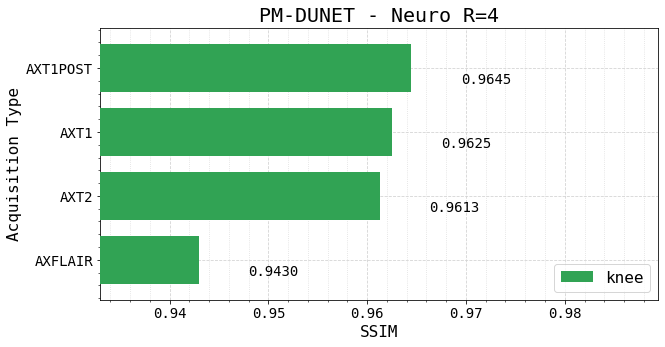

In [4]:
anatomy ='brain'
Reval = 4

acq_type = 'MoDL'
scanner_model = 'Skyra'

eval_metric = 'SSIM'
eval_dset = ['knee 100'] # name of dataset in csv
disp_dset = ['knee'] # display name of dataset

df_raw = pd.read_csv(f'./resources/{anatomy}/eval_{anatomy}_R{Reval}.csv')

networks = df_raw.network.unique()
network_type = 'PM-DUNET'
print(networks)

acq_types = df_raw.acquisition.unique() #acquisition types: ['AXFLAIR', 'AXT1POST', 'AXT1', 'AXT2']
scanner_models = df_raw.systemModel.unique() #scanner models: ['Skyra' 'Aera' 'Biograph_mMR' 'Prisma_fit' 'TrioTim' 'Avanto']

figid, title, _ = plotting_utils.get_plotting_info(anatomy, Reval)
legend = plotting_utils.get_legend(eval_dset, disp_dset)

# drop columns we are currently not interested in evaluation
#df = df_raw.drop(columns=['receiverChannels', 'systemVendor', 'systemFieldStrength_T', 'filename', 'path', 'receiverChannels', 'TR', 'TE', 'TI', 'flipAngle_deg', 'sequence_type', 'echo_spacing'], inplace=False)

df = df_raw
# evaluate wrt. SSIM and drop other measures
drop_metric = [m for m in ['MSE', 'PSNR', 'NMSE', 'SSIM'] if m != eval_metric]
df.drop(columns=drop_metric, inplace=True)

# drop rows that are not of the acquisition type
df = df[df.network == network_type]

model_keys = df['acquisition'].unique()
anatomy_keys = df['anatomy'].unique()

# only evaluate for knee 100 (full fastMRI knee dataset) and neuro data (full fastMRI neuro dataset)
anatomy_keys = [key for key in anatomy_keys if key in eval_dset]

x, y = get_plotting_data(df, model_keys, anatomy_keys, eval_metric, network_column='acquisition')
print(x)
xlim = get_xlim(eval_metric='SSIM', series=x)
ticks = get_ticks(eval_metric='SSIM', xlim=xlim)

# setup figure
ax = x.plot(kind='barh',
            xlim=xlim,
            figsize=(10,5),
            width=0.75,
            color=plotting_utils.get_color(y.index), 
            zorder=3,  
            fontsize=14)

ax.set_title(network_type + ' - ' + title , fontsize=20)
ax.set_ylabel('Acquisition Type', fontsize=16)
ax.set_xlabel(eval_metric, fontsize=16)
ax.legend(handles=legend, loc='lower right', fontsize=16)

# display metric
for i, v in enumerate(y):
    ax.text(v + 0.005, i - 0.25, f'{v:0.4f}', color='black', fontsize=14, zorder=2)

# add grid
ax.grid(zorder=0, color='lightgray', linestyle='dotted',which='minor',axis='x', alpha=0.8)
ax.grid(zorder=0, color='lightgray', linestyle='dashed',which='major')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.minorticks_on()